# Bird Identification Using Machine Learning

## Purpose
This application identifies and displays key information about the bird species present within a dataset of images.  This dataset has been split into a number of different surveys that allow the user to select which location they are interested in examining. After a selection is made, the program will display descriptive visualizations of the survey selected. Next, by utizling a Convolutional Neural Network (CNN), a type of machine learning algorithm, the application will predict which bird species are present within the survey selected. Finally, the user can test the accuracy of the algorithm by running a classification report.


## Imports

In [65]:
#imports

import os
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tabulate as tabulate
import ipywidgets as widgets
import statistics
import math

from IPython.display import Javascript, display
from scipy import stats
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Activation,Dropout,BatchNormalization, Input
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

## Dropbox Settings

In [2]:
#survey dropbox functions
def get_surveys(path):
    surveys = []
    for name in os.listdir(path):
        surveys.append((name, path + name))

    return surveys

survey_dir = 'resources/survey_data/'


#dropbox options and creation
surveys = get_surveys(survey_dir)
survey_dropdown = widgets.Dropdown(
    options = surveys,
    description = 'Survey Data:',
)

## Dataset Object

In [3]:
#dataset declaration
class Dataset:
    data = []

    def __init__(self, path):
        self.path = path
        for sub_dir in os.listdir(path):
            if not os.path.isdir(path + '/' + sub_dir):
                return

            # (bird species name, amount)
            self.data.append((sub_dir, len(os.listdir(path + '/' + sub_dir))))

        self.data = sorted(self.data, key=lambda x: x[1], reverse=True)

    def get_data(self):
        return self.data

    def get_amounts(self):
        amounts = []
        for data in self.data:
            amounts.append(data[1])

        return amounts

    def get_classes(self):
        classes = []
        for data in self.data:
            classes.append(data[0])

        return classes

    def total_class(self):
        return len(self.data)

    def total_amount(self):
        total = 0
        for data in self.data:
            total += data[1]

        return total

    def avg_amount(self):
        return self.total_amount() / self.total_class()

    def mode_amount(self):
        amounts = self.get_amounts()
        return max(set(amounts), key=amounts.count)

    def median_amount(self):
        return statistics.median(self.get_amounts())

    def std_div_amount(self):
        return statistics.stdev(self.get_amounts())

    def min_amount(self):
        min_amt = 99999

        for data in self.data:
            if data[1] < min_amt:
                min_amt = data[1]
                min_class = data[0]

        return min_class, min_amt

    def max_amount(self):
        max_amt = 0

        for data in self.data:
            if data[1] > max_amt:
                max_amt = data[1]
                max_class = data[0]

        return max_class, max_amt

    def top_class(self, amt_to_return=1):
        top_classes = []
        for data in self.data:

            if amt_to_return < 1:
                return top_classes

            top_classes.append(data)

            amt_to_return -= 1

        return top_classes  
    
    def get_path(self):
        return self.path

## Report Functions

### Donut Chart

In [44]:
# donut chart of top bird species
def print_donut(data, display_amount=7):

    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    plt.title(' Top ' + display_amount.__str__() + ' Species of Birds')

    classes = data.get_classes()
    amounts = data.get_amounts()
    final_amounts = []
    for i in range(0, display_amount):
        final_amounts.append(amounts[i])

    wedges, texts = ax.pie(final_amounts, wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.5", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(amounts[i].__str__() + ' ' + classes[i], xy=(x, y), xytext=(1.35 * np.sign(x), 1.4 * y),
                    horizontalalignment=horizontalalignment, **kw)

    #ax.set_title(os.path.basename(data.get_dir()))

    plt.show()

### Statistics Tables

In [107]:
#total table
def print_total(data: Dataset):
    print(tabulate.tabulate(dataset.get_data(), headers=['Bird Species', 'Amount Seen'], tablefmt='fancy_grid'))
    
#stat table
def print_stat(data: Dataset):
    report_data = []

    report_data.append(('Total Birds', data.total_amount()))
    report_data.append(('Total Species', data.total_class()))
    report_data.append(('Most Frequent Species', data.max_amount()))
    report_data.append(('Least Frequent Species', data.min_amount()))
    report_data.append(('Avg Birds Per Species', data.avg_amount()))
    report_data.append(('Mode Birds Per Species', data.mode_amount()))
    report_data.append(('Median Birds Per Species', data.median_amount()))
    report_data.append(('Standard Deviation of Amounts', data.std_div_amount()))

    print(tabulate.tabulate(report_data, headers=['Statistic', 'Value'], tablefmt='fancy_grid'))

### Scatter Plot with Best Fit

In [108]:
#scatter plot of number of characters in bird names v amount of images
def print_scatter(dataset: Dataset):
    data = dataset.get_data()
    x = []
    y = []
    
    for species in data:
        x.append(len(species[0]))
        y.append(species[1])
        
    x = np.array(x)
    y = np.array(y)
        
    fig, ax = plt.subplots()
    ax.set_xlabel('Number of Characters in Species Name')
    ax.set_ylabel('Amount of Birds in Survey')
    plt.scatter(x,y)
    
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x+b, 'r')
    

### Bar Chart

In [109]:
# bar chart of all bird species
def print_bar(data : Dataset):
    classes = data.get_classes()
    amounts = data.get_amounts()
    
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(classes, amounts, height=0.3, align='edge', linewidth=1)
    ax.set_yticks(classes)
    ax.set_yticklabels(data.get_classes())
    ax.grid(False)
    ax.invert_yaxis()
    ax.tick_params(bottom=True, left=False)
    ax.set_xlabel('Amount')
    ax.set_title('Bird Species Present in Survey')
    

## Convolutional Neural Network

### Generate model structure and load trained model

In [32]:
#create the structure of the model
img_shape=(128,128,3)
input=Input(shape=img_shape)

x=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", pooling='max')(input) 
x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)        
output=Dense(275, activation='softmax')(x)
model=Model(inputs=input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#load the trained model
model = load_model('resources/saved_model/trained_bird_id')

#display information about the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 275)               70675     
                                                             

### Verification of the Model's Accuracy

In [92]:
#classification report
ytrue=[]
for images, label in valid_ds:   
    for e in label:
        ytrue.append(class_names[e]) # list of class names associated with each image file in test dataset 
ypred=[]
errors=0
count=0
preds=model.predict(valid_ds, verbose=1) # predict on the test data
for i, p in enumerate(preds):
    count +=1
    index=np.argmax(p) # get index of prediction with highest probability
    klass=class_names[index] 
    ypred.append(klass)  
    if klass != ytrue[i]:
        errors +=1
acc= (count-errors)* 100/count
msg=f'there were {count-errors} correct predictions in {count} tests for an accuracy of {acc:6.2f} % '
print(msg) 
ypred=np.array(ypred)
ytrue=np.array(ytrue)
clr = classification_report(ytrue, ypred, target_names=class_names)
print("Classification Report:\n----------------------\n", clr)  

46/46 [==============================] - 32s 702ms/step
there were 1340 correct predictions in 1375 tests for an accuracy of  97.45 % 
Classification Report:
----------------------
                              precision    recall  f1-score   support

      AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
          AFRICAN FIREFINCH       1.00      1.00      1.00         5
                  ALBATROSS       1.00      1.00      1.00         5
       ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
            AMERICAN AVOCET       1.00      1.00      1.00         5
           AMERICAN BITTERN       0.83      1.00      0.91         5
              AMERICAN COOT       1.00      1.00      1.00         5
         AMERICAN GOLDFINCH       1.00      1.00      1.00         5
           AMERICAN KESTREL       1.00      1.00      1.00         5
             AMERICAN PIPIT       1.00      1.00      1.00         5
          AMERICAN REDSTART       1.00      0.80      0.89

## Survey Results
### Select Survey Data

In [100]:
#survey selection box
display(survey_dropdown)

def run_survey(b):
    display(Javascript('IPython.notebook.execute_cells_below()'))
    
button = widgets.Button(description = 'Run Analysis')
button.on_click(run_survey)
display(button)

<IPython.core.display.Javascript object>

Dropdown(description='Survey Data:', index=1, options=(('alpha', 'resources/survey_data/alpha'), ('beta', 'res…

Button(description='Run Analysis', style=ButtonStyle())

## Descriptive Methods

The descriptive methods in this section highlight important information contained within the bird survey. The most frequent species are displayed with an interactive pie chart that allows the user to select how many birds they want displayed. Next, the bar graph displays the names and totals of the birds present in the survey. A number of statistical tables are available for a summary of the important points.

In [111]:
dataset = Dataset(survey_dropdown.value)
#donut
def onSliderUpdate(x):
    print_donut(dataset, x)

widgets.interact(onSliderUpdate, x=widgets.IntSlider(min=3, max=10, step=1, value=5));

interactive(children=(IntSlider(value=5, description='x', max=10, min=3), Output()), _dom_classes=('widget-int…

In [102]:
#stat table
print_stat(dataset)

╒═══════════════════════════════╤═════════════════════════════════════╕
│ Statistic                     │ Value                               │
╞═══════════════════════════════╪═════════════════════════════════════╡
│ Total Birds                   │ 2133                                │
├───────────────────────────────┼─────────────────────────────────────┤
│ Total Species                 │ 273                                 │
├───────────────────────────────┼─────────────────────────────────────┤
│ Most Frequent Species         │ ('YELLOW BELLIED FLOWERPECKER', 33) │
├───────────────────────────────┼─────────────────────────────────────┤
│ Least Frequent Species        │ ('NOISY FRIARBIRD', 2)              │
├───────────────────────────────┼─────────────────────────────────────┤
│ Avg Birds Per Species         │ 7.813186813186813                   │
├───────────────────────────────┼─────────────────────────────────────┤
│ Mode Birds Per Species        │ 5                             

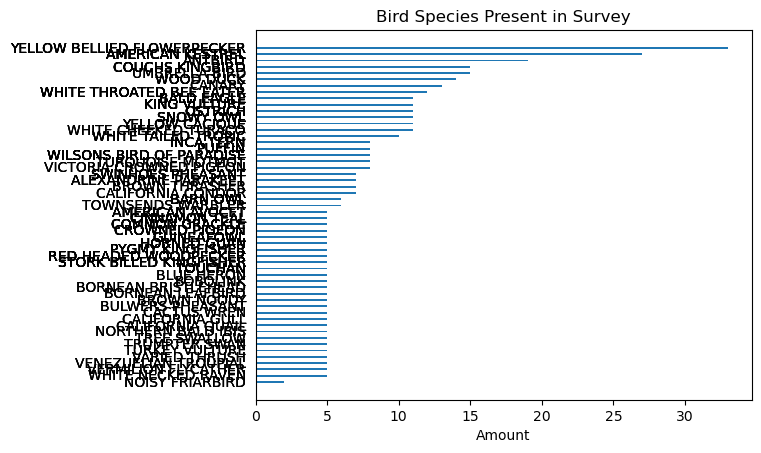

In [103]:
#horiz bar

print_bar(dataset)

In [104]:
#total table
print_total(dataset)

╒═════════════════════════════╤═══════════════╕
│ Bird Species                │   Amount Seen │
╞═════════════════════════════╪═══════════════╡
│ YELLOW BELLIED FLOWERPECKER │            33 │
├─────────────────────────────┼───────────────┤
│ YELLOW BELLIED FLOWERPECKER │            33 │
├─────────────────────────────┼───────────────┤
│ AMERICAN KESTREL            │            27 │
├─────────────────────────────┼───────────────┤
│ AMERICAN KESTREL            │            27 │
├─────────────────────────────┼───────────────┤
│ ANTBIRD                     │            19 │
├─────────────────────────────┼───────────────┤
│ ANTBIRD                     │            19 │
├─────────────────────────────┼───────────────┤
│ COUCHS KINGBIRD             │            15 │
├─────────────────────────────┼───────────────┤
│ COUCHS KINGBIRD             │            15 │
├─────────────────────────────┼───────────────┤
│ COUCHS KINGBIRD             │            15 │
├─────────────────────────────┼─────────

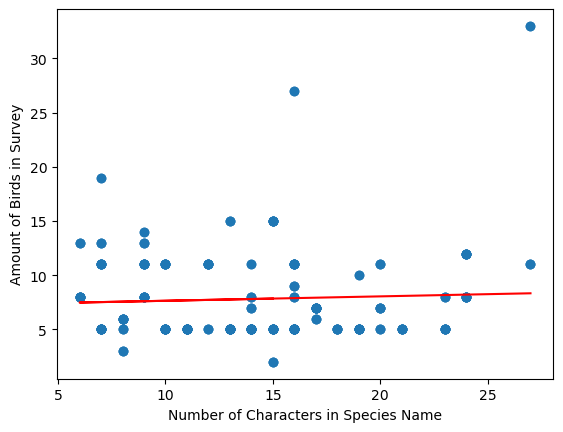

In [105]:
# scatter plot with line of best fit
print_scatter(dataset)

## Predictive

This section loads a model that has been trained against a large dataset of bird images. The model will predict which bird species are present in the survey data. These predictions will be displayed above the image for the first 30 images in the survey data.

Found 236 files belonging to 35 classes.
Found 1375 files belonging to 275 classes.
8/8 [==============================] - 6s 734ms/step


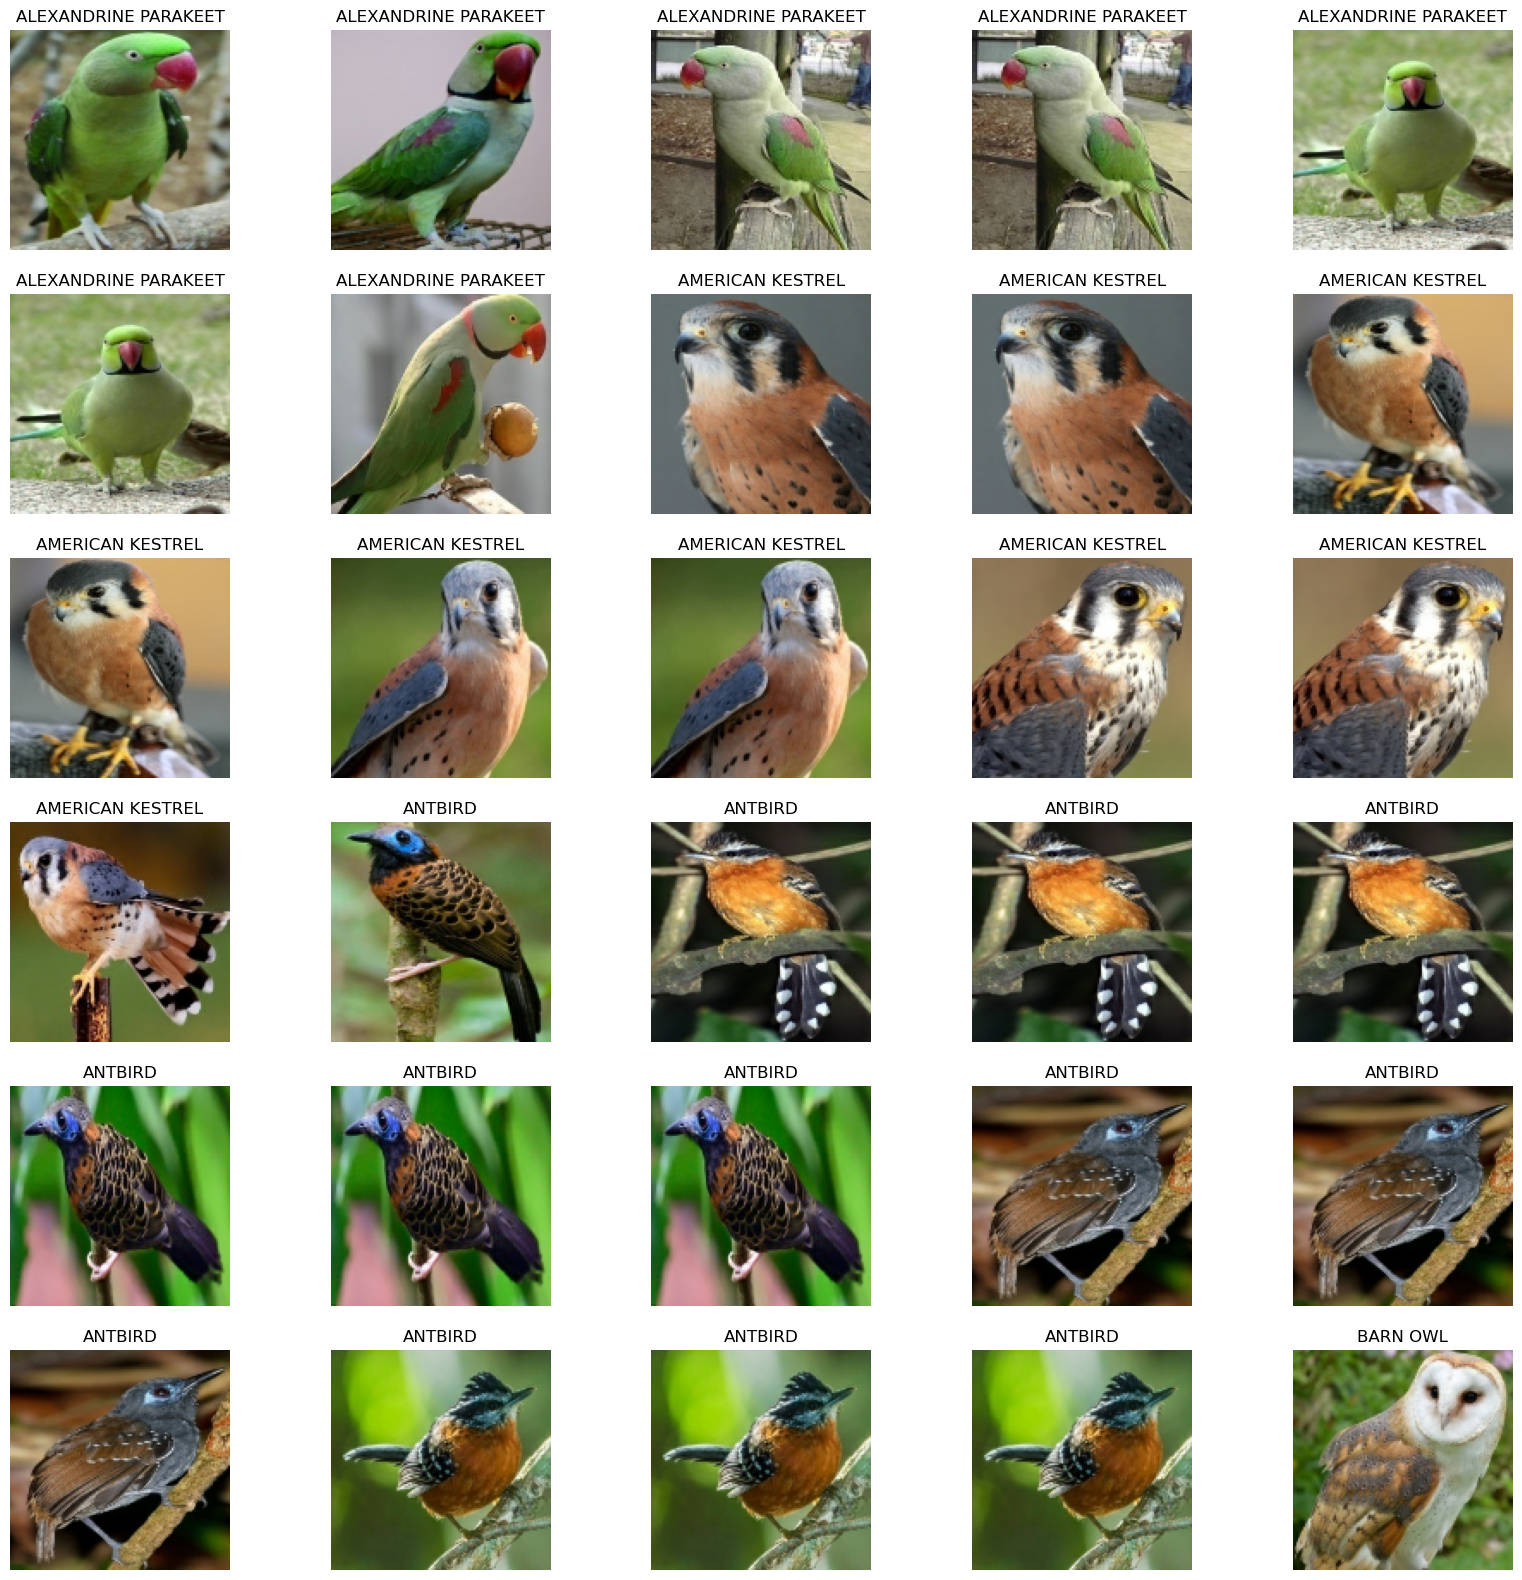

Errors:  1


In [106]:
# grid view of the first 30 images in a dataset

#create the image datasets
img_size = (img_shape[0], img_shape[1])
predict_ds = tf.keras.preprocessing.image_dataset_from_directory(
            dataset.get_path(), image_size=img_size, seed=123, shuffle = False, batch_size=30)
valid_ds=tf.keras.preprocessing.image_dataset_from_directory(
            survey_dir + 'valid', image_size=img_size, seed=123, shuffle = False, batch_size=30)

class_names = valid_ds.class_names
    
preds = model.predict(predict_ds, verbose=1)
ytrue = []


for images, label in predict_ds:
    for e in label:
        ytrue.append(predict_ds.class_names[e]) # list of class names associated with each image file in test dataset
        
ypred = []
errors = 0
count = 0

for i, p in enumerate(preds):
    count +=1
    index=np.argmax(p) # get index of prediction with highest probability
    klass=class_names[index] 
    ypred.append(klass)  
    if klass != ytrue[i]:
        errors +=1

ypred = np.array(ypred)
ytrue = np.array(ytrue)

plt.figure(figsize=(20, 20))


for images, labels in predict_ds.take(1):
    for i in range(0, 30):
        plt.subplot(6, 5, i + 1)
        img = images[i]/255
        plt.title(ypred[i])
        plt.imshow(img)
        plt.axis('off')

plt.show()
print('Errors: ', errors)